In [1]:
!pip install gensim

In [2]:
# Importing Libraries..
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
from collections import Counter
# packages from gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# packages from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

#packages from nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag
import nltk
nltk.download('averaged_perceptron_tagger')

import warnings
warnings.filterwarnings('ignore')

D:\anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Loading the training data..
comments_train=pd.read_csv("C:/Users/Hp/Desktop/Malignant Comments Classifier Project/train.csv")
comments_train.head()

id                                       comment_text  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   

   malignant  highly_malignant  rude  threat  abuse  loathe  
0          0                 0     0       0      0       0  
1          0                 0     0       0      0       0  
2          0                 0     0       0      0       0  
3          0                 0     0       0      0       0  
4          0                 0     0       0      0       0

In [4]:
# Loading the test data..
comments_test=pd.read_csv("C:/Users/Hp/Desktop/Malignant Comments Classifier Project/test.csv")
comments_test.head()

id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.

In [5]:
# checking the features,duplicate values and nan values in the Datasets

print("\nFeatures Present in the Dataset: \n", comments_train.columns)
shape=comments_train.shape
print("\nTotal Number of Rows : ",shape[0])
print("Total Number of Features : ", shape[1])
print("\n\nData Types of Features :\n", comments_train.dtypes)
print("\nDataset contains any NaN/Empty cells : ", comments_train.isnull().values.any())
print("\nTotal number of empty rows in each feature:\n", comments_train.isnull().sum(),"\n\n")
print("Total number of unique values in each feature:")
for col in comments_train.columns.values:
    print("Number of unique values of {} : {}".format(col, comments_train[col].nunique()))


Features Present in the Dataset: 
 Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')

Total Number of Rows :  159571
Total Number of Features :  8


Data Types of Features :
 id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object

Dataset contains any NaN/Empty cells :  False

Total number of empty rows in each feature:
 id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64 


Total number of unique values in each feature:
Number of unique values of id : 159571
Number of unique values of comment_text : 159571
Number of unique values of malignant : 2
Number of unique values of highly_malignant : 2
Number

In [6]:
# Checking value counts for each feature..
cols=['malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe',]
for col in cols:
    print("Number of value_counts of {} : {}".format(col, comments_train[col].nunique()))
    print(comments_train[f'{col}'].value_counts())

Number of value_counts of malignant : 2
0    144277
1     15294
Name: malignant, dtype: int64
Number of value_counts of highly_malignant : 2
0    157976
1      1595
Name: highly_malignant, dtype: int64
Number of value_counts of rude : 2
0    151122
1      8449
Name: rude, dtype: int64
Number of value_counts of threat : 2
0    159093
1       478
Name: threat, dtype: int64
Number of value_counts of abuse : 2
0    151694
1      7877
Name: abuse, dtype: int64
Number of value_counts of loathe : 2
0    158166
1      1405
Name: loathe, dtype: int64


In [7]:
# Dropping features which are not giving any useful information
comments_train.drop(['id'],axis=1,inplace=True)

In [8]:
# Statistical summary
comments_train.describe()

malignant  highly_malignant           rude         threat  \
count  159571.000000     159571.000000  159571.000000  159571.000000   
mean        0.095844          0.009996       0.052948       0.002996   
std         0.294379          0.099477       0.223931       0.054650   
min         0.000000          0.000000       0.000000       0.000000   
25%         0.000000          0.000000       0.000000       0.000000   
50%         0.000000          0.000000       0.000000       0.000000   
75%         0.000000          0.000000       0.000000       0.000000   
max         1.000000          1.000000       1.000000       1.000000   

               abuse         loathe  
count  159571.000000  159571.000000  
mean        0.049364       0.008805  
std         0.216627       0.093420  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000

In [9]:
# Checking null values
comments_train.isnull().sum()

comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

In [10]:
# Checking average length, maximum length of a comment
lens = comments_train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.138847284281, 590.7253812496405, 5000)

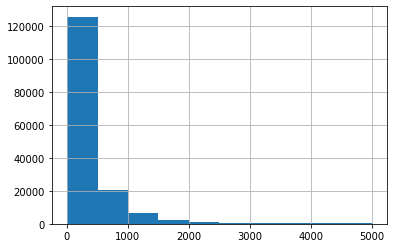

In [11]:
# Plotting length in a histogram
lens.hist()

In [12]:
# Correlation chart
comments_train.corr().style.background_gradient(cmap='YlGnBu')

In [13]:
# Creating a new feature having malignant and non malignant information for the particular comment.
label_cols = [ 'malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe']
comments_train['label'] = 1-comments_train[label_cols].max(axis=1)
comments_train.describe()

malignant  highly_malignant           rude         threat  \
count  159571.000000     159571.000000  159571.000000  159571.000000   
mean        0.095844          0.009996       0.052948       0.002996   
std         0.294379          0.099477       0.223931       0.054650   
min         0.000000          0.000000       0.000000       0.000000   
25%         0.000000          0.000000       0.000000       0.000000   
50%         0.000000          0.000000       0.000000       0.000000   
75%         0.000000          0.000000       0.000000       0.000000   
max         1.000000          1.000000       1.000000       1.000000   

               abuse         loathe          label  
count  159571.000000  159571.000000  159571.000000  
mean        0.049364       0.008805       0.898321  
std         0.216627       0.093420       0.302226  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       1.000000  
50%         0.000000       0.000000       1.000000  
75%         0.000000       0.000000       1.000000  
max         1.000000       1.000000       1.000000

In [14]:
# 1: NON Malignant and 0: Malignant comments
comments_train.label.value_counts()

1    143346
0     16225
Name: label, dtype: int64

## Data Preprocessing

In [15]:
# New feature (length) contains length of the content feature..
comments_train['length'] = comments_train.comment_text.str.len()
comments_train.head()

comment_text  malignant  \
0  Explanation\nWhy the edits made under my usern...          0   
1  D'aww! He matches this background colour I'm s...          0   
2  Hey man, I'm really not trying to edit war. It...          0   
3  "\nMore\nI can't make any real suggestions on ...          0   
4  You, sir, are my hero. Any chance you remember...          0   

   highly_malignant  rude  threat  abuse  loathe  label  length  
0                 0     0       0      0       0      1     264  
1                 0     0       0      0       0      1     112  
2                 0     0       0      0       0      1     233  
3                 0     0       0      0       0      1     622  
4                 0     0       0      0       0      1      67

In [16]:
#     Here, a function has been made in which all the Data cleaning steps like removing data which is not useful like 
#       email address, mobile numbers,removing punctuations, converting all the documents into lowercase, 
#           using lemmatization technique, filtering documents using Stopwords, using POS tagging,
#      all these type of data preprocessing steps are being perormed with the help of the function defined below.

# function to filter using POS tagging..
def get_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function for data cleaning...
def Processed_data(comments):
    # Replace email addresses with 'email'
    comments=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ', comments)
        
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    comments=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ',comments)
        
    # getting only words(i.e removing all the special characters)
    comments = re.sub(r'[^\w]', ' ', comments) 
        
    # getting only words(i.e removing all the" _ ")
    comments = re.sub(r'[\_]', ' ', comments) 
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
    comments=re.sub(r'\s+[a-zA-Z]\s+', ' ', comments)
    
    # Removing extra whitespaces
    comments=re.sub(r'\s+', ' ', comments, flags=re.I)

    #converting all the letters of the review into lowercase
    comments = comments.lower()
    
    # splitting every words from the sentences
    comments = comments.split()

    # iterating through each words and checking if they are stopwords or not,
    comments=[word for word in comments if not word in set(STOPWORDS)]
    
    # remove empty tokens
    comments = [text for text in comments if len(text) > 0]
    
    # getting pos tag text
    pos_tags = pos_tag(comments)

    # considering words having length more than 3only
    comments = [text for text in comments if len(text) > 3]        
   
    # performing lemmatization operation and passing the word in get_pos function to get filtered using POS ... 
    comments = [(WordNetLemmatizer().lemmatize(text[0], get_pos(text[1])))for text in pos_tags]

   # considering words having length more than 3 only
    comments = [text for text in comments if len(text) > 3]
    comments = ' '.join(comments)
    return comments

In [17]:
# cleaning the comments and storing them in a separate feature
comments_train["clean_comment_text"] = comments_train["comment_text"].apply(lambda x: Processed_data(x))

In [18]:
# checking the clean comments content..
comments_train["clean_comment_text"]

0         explanation edits username hardcore metallica ...
1         match background colour seemingly stuck thanks...
2         trying edit constantly removing relevant infor...
3         real suggestion improvement wondered section s...
4                                 hero chance remember page
                                ...                        
159566    second time asking view completely contradicts...
159567                     ashamed horrible thing talk page
159568    spitzer there actual article prostitution ring...
159569       look like actually speedy version deleted look
159570    think understand came idea right away kind com...
Name: clean_comment_text, Length: 159571, dtype: object

In [19]:
# New feature (Clean_length) contains length of the clean_comment_text feature after puncuations, stopwords removal..
comments_train['Clean_length'] = comments_train.clean_comment_text.str.len()
comments_train.head()

comment_text  malignant  \
0  Explanation\nWhy the edits made under my usern...          0   
1  D'aww! He matches this background colour I'm s...          0   
2  Hey man, I'm really not trying to edit war. It...          0   
3  "\nMore\nI can't make any real suggestions on ...          0   
4  You, sir, are my hero. Any chance you remember...          0   

   highly_malignant  rude  threat  abuse  loathe  label  length  \
0                 0     0       0      0       0      1     264   
1                 0     0       0      0       0      1     112   
2                 0     0       0      0       0      1     233   
3                 0     0       0      0       0      1     622   
4                 0     0       0      0       0      1      67   

                                  clean_comment_text  Clean_length  
0  explanation edits username hardcore metallica ...           129  
1  match background colour seemingly stuck thanks...            64  
2  trying edit constantly removing relevant infor...           112  
3  real suggestion improvement wondered section s...           315  
4                          hero chance remember page            25

In [20]:
# malignant comments
comments_train[comments_train['label']==0]

comment_text  malignant  \
6            COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK          1   
12      Hey... what is it..\n@ | talk .\nWhat is it......          1   
16      Bye! \n\nDon't look, come or think of comming ...          1   
42      You are gay or antisemmitian? \n\nArchangel WH...          1   
43               FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!          1   
...                                                   ...        ...   
159494  "\n\n our previous conversation \n\nyou fuckin...          1   
159514                  YOU ARE A MISCHIEVIOUS PUBIC HAIR          1   
159541  Your absurd edits \n\nYour absurd edits on gre...          1   
159546  "\n\nHey listen don't you ever!!!! Delete my e...          1   
159554  and i'm going to keep posting the stuff u dele...          1   

        highly_malignant  rude  threat  abuse  loathe  label  length  \
6                      1     1       0      1       0      0      44   
12                     0     0       0      0       0      0     319   
16                     0     0       0      0       0      0      57   
42                     0     1       0      1       1      0     648   
43                     0     1       0      1       0      0      40   
...                  ...   ...     ...    ...     ...    ...     ...   
159494                 0     1       0      1       1      0    1677   
159514                 0     0       0      1       0      0      33   
159541                 0     1       0      1       0      0     346   
159546                 0     0       0      1       0      0     534   
159554                 0     1       0      1       0      0     182   

                                       clean_comment_text  Clean_length  
6                                    cocksucker piss work            20  
12      talk exclusive group taliban good destroying s...           171  
16                         look come think comming tosser            30  
42      antisemmitian archangel white tiger meow greet...           313  
43                                     fuck filthy mother            18  
...                                                   ...           ...  
159494  previous conversation fucking shit eating libe...           826  
159514                            mischievious pubic hair            23  
159541  absurd edits absurd edits great white shark to...           198  
159546  listen delete edits annoyed 2k15 roster confir...           199  
159554  going posting stuff deleted fucking site close...            93  

[16225 rows x 11 columns]

In [21]:
# non malignant comments
comments_train[comments_train['label']==1]

comment_text  malignant  \
0       Explanation\nWhy the edits made under my usern...          0   
1       D'aww! He matches this background colour I'm s...          0   
2       Hey man, I'm really not trying to edit war. It...          0   
3       "\nMore\nI can't make any real suggestions on ...          0   
4       You, sir, are my hero. Any chance you remember...          0   
...                                                   ...        ...   
159566  ":::::And for the second time of asking, when ...          0   
159567  You should be ashamed of yourself \n\nThat is ...          0   
159568  Spitzer \n\nUmm, theres no actual article for ...          0   
159569  And it looks like it was actually you who put ...          0   
159570  "\nAnd ... I really don't think you understand...          0   

        highly_malignant  rude  threat  abuse  loathe  label  length  \
0                      0     0       0      0       0      1     264   
1                      0     0       0      0       0      1     112   
2                      0     0       0      0       0      1     233   
3                      0     0       0      0       0      1     622   
4                      0     0       0      0       0      1      67   
...                  ...   ...     ...    ...     ...    ...     ...   
159566                 0     0       0      0       0      1     295   
159567                 0     0       0      0       0      1      99   
159568                 0     0       0      0       0      1      81   
159569                 0     0       0      0       0      1     116   
159570                 0     0       0      0       0      1     189   

                                       clean_comment_text  Clean_length  
0       explanation edits username hardcore metallica ...           129  
1       match background colour seemingly stuck thanks...            64  
2       trying edit constantly removing relevant infor...           112  
3       real suggestion improvement wondered section s...           315  
4                               hero chance remember page            25  
...                                                   ...           ...  
159566  second time asking view completely contradicts...           157  
159567                   ashamed horrible thing talk page            32  
159568  spitzer there actual article prostitution ring...            61  
159569     look like actually speedy version deleted look            46  
159570  think understand came idea right away kind com...            86  

[143346 rows x 11 columns]

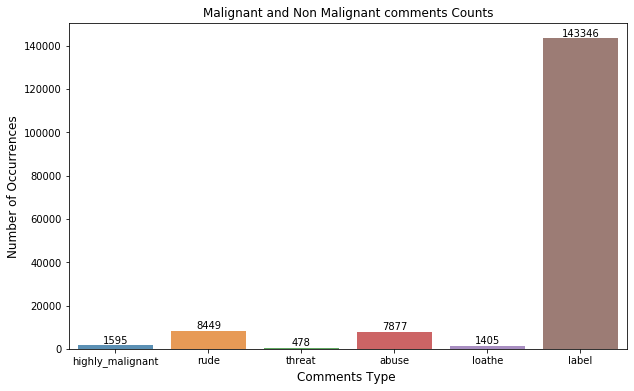

In [22]:
# Comment categories Counts
x=comments_train.iloc[:,2:8].sum()
#plot
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Malignant and Non Malignant comments Counts")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Comments Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [23]:
# Tokenizing Documents..
data=[]
from nltk.tokenize import word_tokenize
for j,i in enumerate(comments_train['clean_comment_text']):
    a=word_tokenize(i,'english')
    data.append(a)

In [24]:
# Making Word dictionary...
dictionary = corpora.Dictionary(data)
print(dictionary)

Dictionary(167144 unique tokens: ['closure', 'doll', 'edits', 'explanation', 'hardcore']...)


# EDA

In [25]:
# diplaying number of counts of labels....
comments_train['label'].value_counts()

1    143346
0     16225
Name: label, dtype: int64

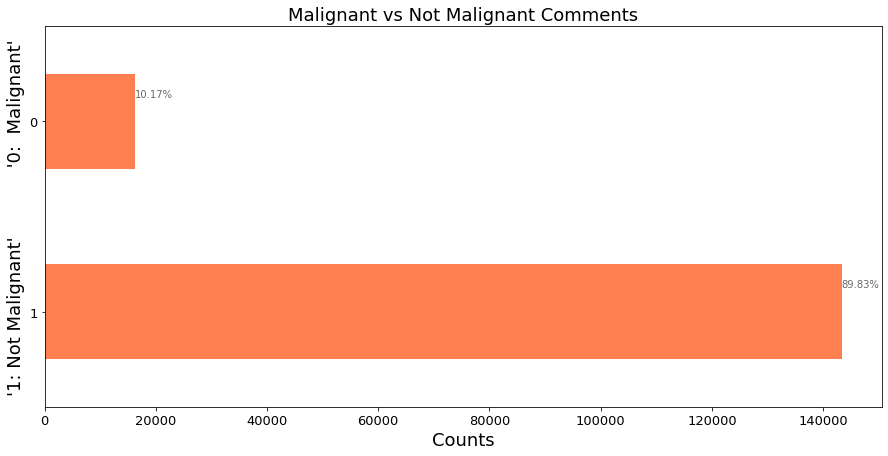

In [26]:
# Displaying the percentage of Malignant and Not Malignant comments in the given dataset...
# Plotting graph using label values from the df_news dataframe

ax = comments_train['label'].value_counts().plot(kind='barh', figsize=(15,7),color="coral", fontsize=13)
ax.set_alpha(0.8)

# Setting up title and labels
ax.set_title("Malignant vs Not Malignant Comments", fontsize=18)
ax.set_xlabel("Counts",  fontsize=18)
ax.set_ylabel("'1: Not Malignant'            '0:  Malignant'", fontsize=18)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar labels using above list
total = sum(totals)

# set individual bar labels using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, str(round((i.get_width()/total)*100, 2))+'%', fontsize=10,color='dimgrey')

In [27]:
#for counting frequently occurence of Malignant and not Malignant words.
count1 = Counter(" ".join(comments_train[comments_train['label']==0]["clean_comment_text"]).split()).most_common(200)
count2 = Counter(" ".join(comments_train[comments_train['label']==1]["clean_comment_text"]).split()).most_common(200)
df=pd.DataFrame()
print("TOP 200 Words in Each Category (Word,Counts)")
df['Malignant Words']=count1
df['Not Malignant Words']=count2
df.head(10)

TOP 200 Words in Each Category (Word,Counts)


Malignant Words Not Malignant Words
0      (fuck, 10080)    (article, 72346)
1       (suck, 4696)       (page, 54388)
2  (wikipedia, 3939)  (wikipedia, 44659)
3       (like, 3937)       (talk, 36421)
4       (shit, 3708)       (like, 24492)
5     (nigger, 3434)     (source, 21267)
6    (fucking, 3337)      (think, 19270)
7       (page, 2870)       (time, 17840)
8       (hate, 2713)       (know, 17687)
9     (faggot, 2496)       (edit, 17247)

In [28]:
!pip install wordcloud

In [29]:
# Making a wordcloud function in order to show the Malignant and NOT Malignant words from the dataset..
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def Display_wordcloud(data,title):
    feedbackcloud = WordCloud(
        background_color = 'black',
        max_words = 1000,
        max_font_size = 40, 
        scale = 3,
        random_state = 25
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15, 10),facecolor='g')
    plt.axis('off')
    plt.imshow(feedbackcloud)
    plt.title(f"{title} words")
    plt.show()

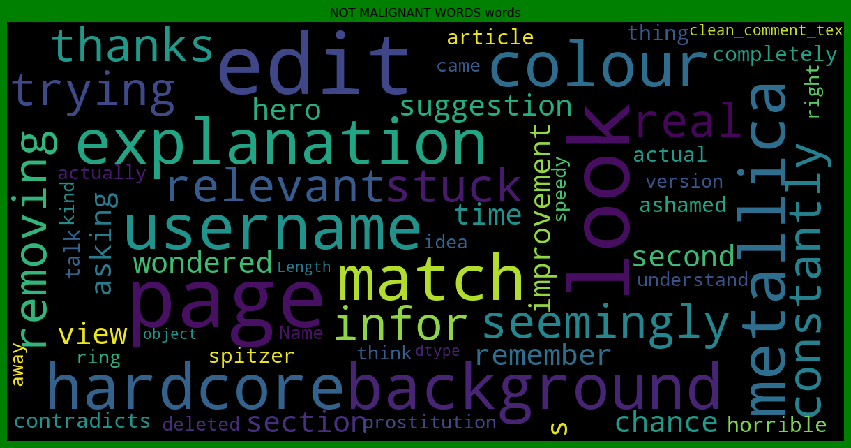

In [30]:
# NOT Malignant words in training data
Display_wordcloud(comments_train['clean_comment_text'][comments_train['label']==1],"NOT MALIGNANT WORDS")

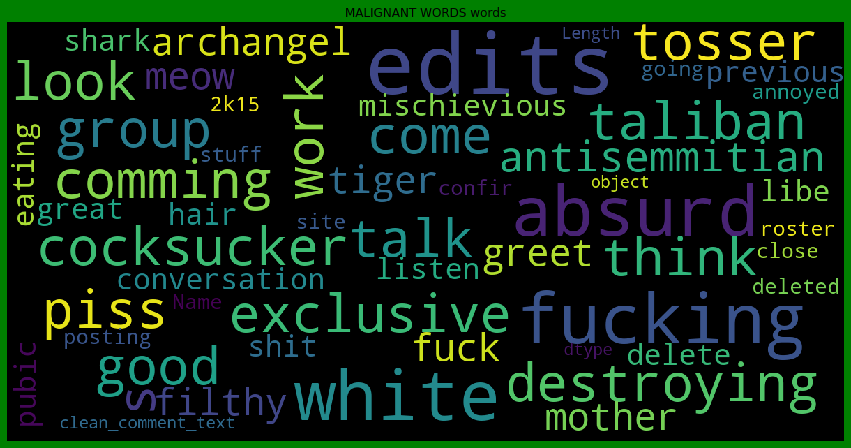

In [31]:
# Malignant words in training data
Display_wordcloud(comments_train['clean_comment_text'][comments_train['label']==0],"MALIGNANT WORDS")

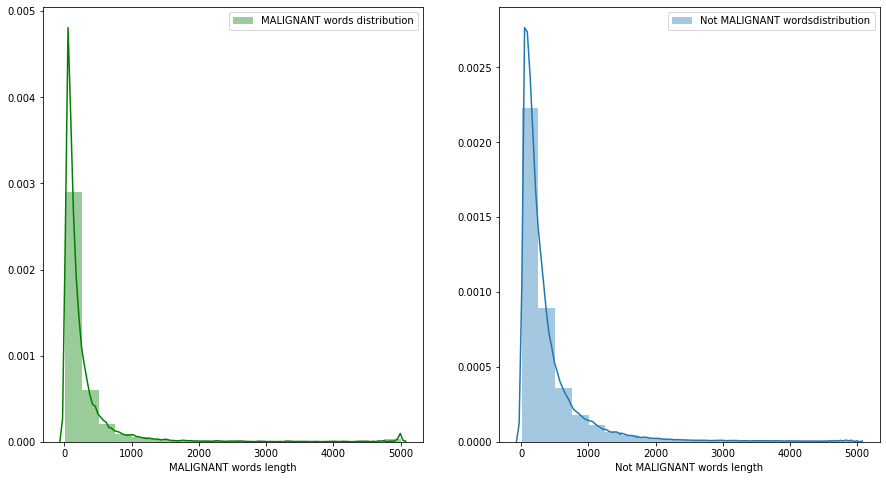

In [32]:
# Comments length distribution BEFORE cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(comments_train[comments_train['label']==0]['length'],bins=20,ax=ax[0],label='MALIGNANT words distribution',color='g')

ax[0].set_xlabel('MALIGNANT words length')
ax[0].legend()

sns.distplot(comments_train[comments_train['label']==1]['length'],bins=20,ax=ax[1],label='Not MALIGNANT wordsdistribution')
ax[1].set_xlabel('Not MALIGNANT words length')
ax[1].legend()

plt.show()

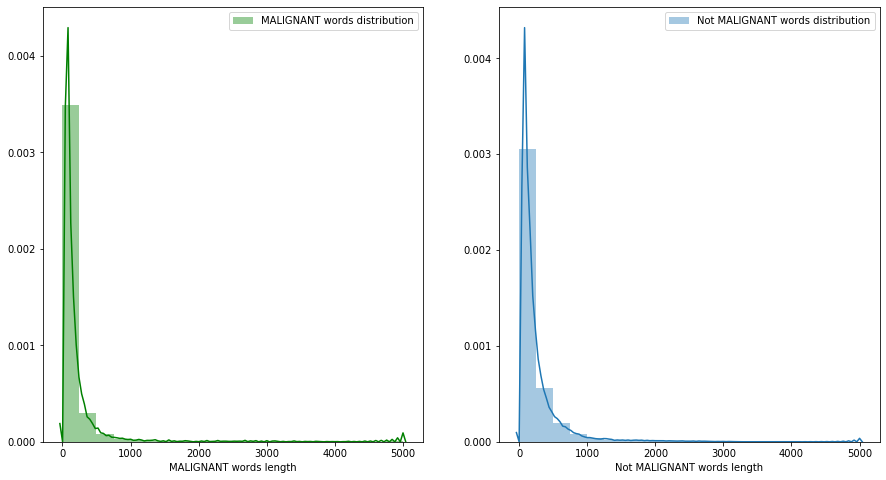

In [33]:
# Comments length distribution after cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(comments_train[comments_train['label']==0]['Clean_length'],bins=20,ax=ax[0],label='MALIGNANT words distribution',color='g')

ax[0].set_xlabel('MALIGNANT words length')
ax[0].legend()

sns.distplot(comments_train[comments_train['label']==1]['Clean_length'],bins=20,ax=ax[1],label='Not MALIGNANT words distribution')
ax[1].set_xlabel('Not MALIGNANT words length')
ax[1].legend()

plt.show()

In [34]:
# creating the TF-IDF(term frequency–inverse document frequency) vectorizer function in order to convert the tokens 
#   from the train documents into vectors so that machine can do further processing
def Tf_idf_train(text):
    tfid = TfidfVectorizer(min_df=3,smooth_idf=False)
    return tfid.fit_transform(text)

In [35]:
# Inserting vectorized values in a variable x, which will be used in training the model 
x=Tf_idf_train(comments_train['clean_comment_text'])

In [36]:
# checking the shape of the data which is inserted in x which will be used for model training.
print("Shape of x: ",x.shape)

# Assigning the label in y and checking it's shape
y = comments_train['label'].values
print("Shape of y: ",y.shape)

Shape of x:  (159571, 43194)
Shape of y:  (159571,)


# Model Training

In [37]:
# Importing useful libraries for model training

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier

# Model selection libraries...
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV


# Importing some metrics we can use to evaluate our model performance.... 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import log_loss

# Creating instances for different Classifiers

LR=LogisticRegression()
MNB=MultinomialNB()
PAC=PassiveAggressiveClassifier()


In [38]:
#Putting Scikit-Learn machine learning Models in a list so that it can be used for further evaluation in loop.
models=[]
models.append(('LogisticRegression',LR))
models.append(('MultinomialNB',MNB))
models.append(('PassiveAggressiveClassifier',PAC))

In [39]:
#        Function which will find best Random State and then calculate Maximum Accuracy Score corresponding to it
#                                  and print accuracy score in one go.
def max_acc_score(clf,x,y):
    max_acc_score=0
    final_r_state=0
    for r_state in range(42,100):
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=r_state,stratify=y)
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        acc_score=accuracy_score(y_test,y_pred)
        if acc_score > max_acc_score:
            max_acc_score=acc_score
            final_r_state=r_state
    print('Max Accuracy Score corresponding to Random State ', final_r_state, 'is:', max_acc_score)
    print('\n')
    return final_r_state

*********** LogisticRegression ***********


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Max Accuracy Score corresponding to Random State  44 is: 0.9543574532085561


Learning Score :  0.9570721313530112
Accuracy Score :  0.9543574532085561
Cross Val Score :  0.9647437317575804
roc auc score :  0.7934277979300925


Log loss :  1.5764709396342023


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.59      0.72      4868
           1       0.96      1.00      0.98     43004

    accuracy                           0.95     47872
   macro avg       0.95      0.79      0.85     47872
weighted avg       0.95      0.95      0.95     47872



Confusion Mat

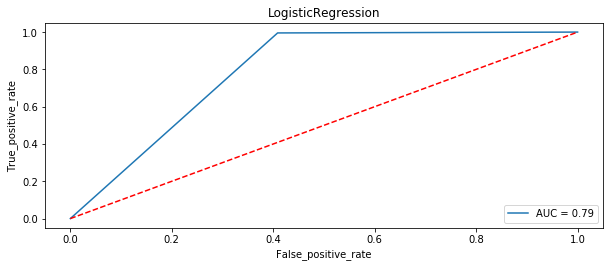

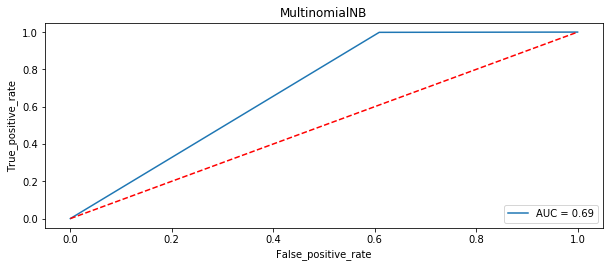

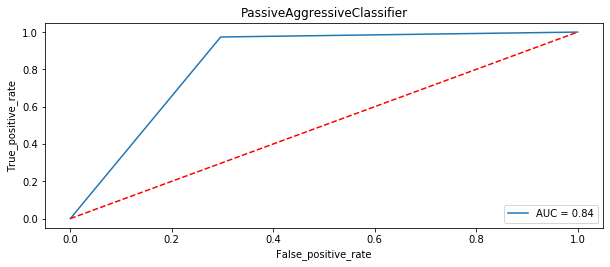

In [40]:
#Lists to store model name, Learning score, Accuracy score, cross_val_score, Auc Roc score .
Model=[]
Score=[]
Acc_score=[]
cvs=[]
rocscore=[]
lg_loss=[]
# For Loop to Calculate Accuracy Score, Cross Val Score, Classification Report, Confusion Matrix

for name,model in models:
    print('***********',name,'***********')
    print('\n')
    Model.append(name)
    print(model)
    print('\n')
    
#Now here I am calling a function which will calculate the max accuracy score for each model and return best random state.
    r_state=max_acc_score(model,x,y)
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=r_state,stratify=y)
    model.fit(x_train,y_train)
#..............Learning Score...........
    score=model.score(x_train,y_train)
    print('Learning Score : ',score)
    Score.append(score*100)
    y_pred=model.predict(x_test)
    acc_score=accuracy_score(y_test,y_pred)
    print('Accuracy Score : ',acc_score)
    Acc_score.append(acc_score*100)
    
#................Finding Cross_val_score..................    
    cv_score=cross_val_score(model,x,y,cv=10,scoring='roc_auc').mean()
    print('Cross Val Score : ', cv_score)
    cvs.append(cv_score*100)
    
#................Roc auc score...........................    
    false_positive_rate,true_positive_rate, thresholds=roc_curve(y_test,y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    print('roc auc score : ', roc_auc)
    rocscore.append(roc_auc*100)
    print('\n')  
    
    loss = log_loss(y_test,y_pred)
    print('Log loss : ', loss)
    lg_loss.append(loss)
    print('\n')

#................Classification Report...........................      
    print('Classification Report:\n',classification_report(y_test,y_pred))
    print('\n')
    
    print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
    print('\n')
    

    
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    plt.plot(false_positive_rate,true_positive_rate,label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True_positive_rate')
    plt.xlabel('False_positive_rate')
    print('\n\n')

In [41]:
# Making a Dataframe comprises of Different Calculated Scores :
result=pd.DataFrame({'Model': Model,'Learning Score': Score,'Accuracy Score': Acc_score,'Cross Val Score':cvs,
                     'Roc_data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAmIAAAELCAYAAAB6RerpAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjAsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+17YcXAAAgAElEQVR4nOzdd3xUVfrH8c+TUEVAEATpKFiwIYai4mIXUGFtCCqCoNhYC6su1rXtWnZX14LrKiogAiIWVFSKbX+iKKFJV6SG3nuAJM/vjzOREBIyQCaT8n2/Xnkxc8+duc/MBe6Tc859jrk7IiIiIlLwEuIdgIiIiEhJpURMREREJE6UiImIiIjEiRIxERERkThRIiYiIiISJ0rEREREROJEiZiIRM3MHjCz/vGOozAwsy1mdlQBHOcbM7sxRu9dL/I5EiPPa5jZ/8xss5n9S+dbJPZKxTsAETl4ZrYQqAGkA1uBz4A/ufuW/DyOu/89P9/PzB4F/gq0dPef8vO9Y83dD82P9zGzMsADwLVALWA18BXwuLsvzI9j5MbdFwNZP0cvYA1QyVVkUqRAqEdMpPi4NJIcNAOaAw/FOZ59MjMDugLrgG4xPE5h/4VzBNABuAaoDJwCTALOi0Ms9YFZB5uEWaDri0gU9A9FpJhx96XA58CJZnaDmc2ODDXNN7ObM/czs2pm9qmZbTCzdWb2f5kXTzP7i5ktjbxurpmdF9n+qJkNjjz+wsx6Zz22mU0zs8sjj48zs7GR955rZp2yhXoWoQfoTqBzpGco830SI0Nja8xsgZn1NjPPTKrMrGGWIbRxZtYvS1wNIvv2NLPFhN4lzKyVmX0f+bzTzOzsLMfrHvl+NkeOd21keyMz+9bMNkZieTfLazzS3srMVmQO70XaLjOznyOPE8ysr5n9ZmZrzWy4mVWNtJ0PXAB0dPeJ7p7m7hvdvZ+7v5H93JrZ0Wb2VeR91pjZO2Z2WJb23M5bCzNLNrNNZrbSzJ7L9l2VMrMBhIT4vshw5flZz3cU3+E3ZvY3MxsPbANiPmwrUhwoERMpZsysLtAemAKsAi4BKgE3AM+bWbPIrn8GUoDqhGHNBwA3s2OB3kBzd68IXAQszOFQQ4AuWY7bhNCjMsrMKgBjI/scEdnvFTM7IcvruwGfAJnJzSVZ2m4C2gFNCT18f8zh2D8BhwOPEnrWsmsDHA9cZGa1gVHAk0BV4B7gfTOrHon1RaBd5POeAUyNvMcTwBigClAHeCn7Qdx9AmE4+Nwsm6+JxAhwRyT+NoTEcz3QL9J2PvCTuy/JIf6cGPBU5H2OB+pGPj95nLcXgBfcvRJwNDA8h8/RHXgHeNbdD3X3cXsceB/fYZbduhKGNysCi6L8TCIlmhIxkeLjIzPbAHwHfAv83d1HuftvHnxLSCrOiuy/CzgSqO/uu9z9/yJDUulAWaCJmZV294Xu/lsOx/sQaGpm9SPPrwU+cPcdhKRqobu/FenlmQy8D1wJYGaHAFcBQ9x9F2F4LuvwZCdC4pDi7uuBpzMbzKweYej1EXff6e7fAR/nEN+j7r7V3bcD1wGfuftn7p7h7mOBZELCCpBB6EEs7+7L3X1mlu+oPlDL3VMjx8rJUCJJqZlVjLzv0EjbzcCDkc+yg5A4XRnp3TscWJ7Le+7F3ee5+1h33+Huq4HnCAke7Pu87QIamVk1d98SSR73V17fIcAAd58ZOee7DuAYIiWOEjGR4uOP7n6Yu9d399vcfbuZtTOzCZHhwQ2Ei2a1yP7/AOYBYyLDcn0hXOyBuwgJwyozG2ZmtbIfzN03E3pIOkc2dSb0qEBIXlpGhrA2RI59LVAz0n4ZkEa4qYDI69pl6V2pBWTtJcr6uBawzt235dKe07b6wFXZ4mkNHOnuW4GrgVuA5WY2ysyOi7zuPkIv1E9mNtPMeuRwHAi9X5ebWVngcmCyu2f2CNUHPsxy3NmEpKkGsJaQDEfFzI6InI+lZrYJGEzkfOZx3noCxwBzzGyimV2Sw9vnJdfvMMs+0fbsiUiEEjGRYiqSFLwP/BOo4e6HERIfg5BIufuf3f0o4FKgT+acIncf4u6tCRdfB57J5TBDgS5mdjpQHvg6sn0J8G0kMcz8OdTdb420dyPcrbfYzFYA7wGl2T3UuZwwFJipbpbHy4GqkV61nNozZZ1wvgR4O1s8Fdz96cjnHe3uFxCSijnA65HtK9z9JnevRejZesXMGu11IPdZhKG4duw5LJl57HbZjl0uMpdvHNDCzOpkf89cPBX5XCdHhhmvI3I+I3HkeN7c/Vd370IYJn4GGBEZkt0f+/wOM0PYz/cUKfGUiIkUX2UIQ1WrgTQzawdcmNloZpdEJpsbsInQS5NuZsea2bmRRC4V2B5py8lnhIv+48C77p4R2f4pcIyZdTWz0pGf5mZ2fGSu0XmE4cumkZ9TCAlC5vDkcOBOM6sdmYz+l8wDRnqakoFHzaxMJAm8NI/vYjBwqZldZOFGgHJmdraZ1bFQO6tDJDHZAWzJ/LxmdlWWJGk9IdHI7bsYQpgP9gdCYpnpVeBvmUO4kXlpHSOfZRxhLt2HZnZaZNJ8RTO7JZfet4qR+DZEvsd7Mxv2dd7M7Dozqx45PxsiL8ntc+Qm1+9wP99HRLJQIiZSTEWGDu8gJDXrCT01WedSNSb0yGwBfgBecfdvCMnb04R6UisIvSgP5HKMHcAHhEnnQ7Js30xI+joDyyLv80zkvbsCU919TKTHaYW7ryBMmD/ZzE4k9EiNAX4m3HTwGWEoMzN5uBY4nTC09yRhwv+OfXwXS4COkc+xmtC7cy/h/8AEwo0LywilNNoAt0Ve2hz40cy2RL67O919QS6HGQqcDXzl7muybH8h8toxZrYZmAC0zNJ+ZeTzvQtsBGYASYRzk91jhJsXNhKGhT/I0rav89YWmBn5HC8And09NZfPkaM8vkMROUDmqtknIoVcpDfvVXevn0v7u8Acd/9rwUYmInJw9JuMiBQ6ZlbezNpHhupqE6rvf5ilvbmFmloJZtaW0FPzUbziFRE5UErERKQwMsIw3HrC0ORs4JEs7TWBbwjDqi8Ct7r7lAKOUUTkoGloUkRERCRO1CMmIiIiEidKxERERETipFS8AzgQ1apV8wYNGsQ7DBEREZE8TZo0aY27V8+prUgmYg0aNCA5OTneYYiIiIjkycwW5damoUkRERGROFEiJiIiIhInSsRERERE4kSJmIiIiEicxDQRM7M3zWyVmc3Ipd3M7EUzm2dmP5tZs1jGIyIiIlKYxLpHbADQdh/t7YDGkZ9ewH9iHI+IiIhIoRHT8hXu/j8za7CPXToCgzysszTBzA4zsyPdfXks4xIREZH95+6kZTjpGU6Ghz9//3EnIwPSMjLIyID0bO2/759le0bkeVrm48h+ex4D0jMywp8e9kvL8tocj7FHTJH9f2+LvJ9DRobT9fT6tDrq8Lh9p/GuI1YbWJLleUpk216JmJn1IvSaUa9evQIJTkREih/PMSEgkhDsTiIyL+B5XuBzTQgiSUnk8e/v57kkHdnfJ8dj7E5Koks69mxLdyctfXd7hmdJnPJKktwp7MtTm0GpBCPBjMQEI9GMxMTwZ4LBCct+5eKp45jaqCnfn/wHEgw2bt8V15jjnYhZDttyPM3u/hrwGkBSUlIh/6sgIhJbWZOJ33sf0ndfSDN8z16GnBKF3NoPtBcia/veSUdmL8TupCTvpCOXno49EpsMMpxck46cvpOikEwkmpGQYJSKJBMJCZHEIjO5SDASEqBUQgIJRnhuRqnELPtH9itTKmF3e8KebZk/IXFhj2MkZEtk9nqPbO+Tuf/udiL7J/z+ODHb58j8jLnHtGd75mfOfJz9OzHLIa1ISYHBg2HQIJg9G8qW5apLm8M9Zxf4uc1JvBOxFKBulud1gGVxikVECpi773kRzbxg7vdv9eH5HklJZhIRVdKx/70Q+046sn2ebPFmDonk+B45Jh17fycZhTyZAPK86JdKSAgX06wX5Fwv1gmUK727PTMh2J0AQGLkgh9d0rH3MRINEhMTIvvze2KzR+9KrklHtphyPMaenznHmCKxyEFKS4NSkRTnkktg2jRo3Rpeew2uugoOOyy+8WUR70TsY6C3mQ0DWgIbNT9MSqL5q7ewftvO3xOH9GwX9T0vwFmTjrx6OvZMSg5seCXb8SPDLZnJRFRJUrahjt3vH+9vPm97XYAt87fwyEU/yt/qEyPJRNlS2ZOOLO9n7L7AJ+4r6dj7GLuPv2d80fZC7CvpyNqz8XsvRA5JSfZjiBSo9HT45pvQ8zVmDMybBxUqwCuvQI0acPTR8Y4wRzFNxMxsKHA2UM3MUoC/AqUB3P1V4DOgPTAP2AbcEMt4RAqjwRMW8dBHOVZ4yTdZfyPf50V8r6Qj59/qDylVKttFP4f9bfdFel89HXsmHexn0hFNTwd7DY3kOISTy/CLiBRyKSnQr18YfkxJgUqV4OqrYcuWkIidcUa8I9ynWN812SWPdgduj2UMIoXZ13NX8cjIGZxzbHW6n9lw/3ohcpw/sffQSIKR87wJEZGias0a2LYN6tWD1avhH/+Aiy6Cf/4TOnSA8uXjHWHU4j00KVJizV6+id7vTOa4mpV4+ZpmVCirf44iIrnasQNGjQpDj6NGwXXXwVtvQdOmsHw5VK8e7wgPiP7nF4mDlZtS6TFgIhXLlebN7s2VhImI7MvDD4fhx/XroWZNuOsuuP760GZWZJMwUCImUuC27Uyj58CJbNy+i/duOZ2alcvFOyQRkcJl4UJ4/324+25ISICMDGjXLiRf5523+47IYqD4fBKRIiA9w7lj6FRmLdtE/25JnFCrcrxDEhEpHDZtCsnXoEHh7keANm0gKQn+9re4hhZLSsRECtDfP5vNuNkreazDCZx7XI14hyMiUjhMnRrubty+HRo3hieeCHPAGjSId2Qxp0RMpIAM+mEhb3y3gBvObEC3MxrEOxwRkfiZMSP0fNWsCX36wAknwK23hmKrLVuGeV8lhBIxkQLw9ZxVPPrxTM4//ggeurhJvMMRESl4K1fC0KEhAZsyJczzuumm0Fa6NPzrX/GNL04S4h2ASHE3a9kmeg+ZzPFHVuKFzqeSqCKhIlJS7Ny5+/Gdd4bJ94mJ8NJLsGxZqHpfwikRE4mhFRtDmYpK5VWmQkRKCHf47jvo1QuOOALmzAnbH3kEZs6EiROhd+8iXXIiP+mqIBIjW3eEMhWbU3fx3i1nUKOSylSISDG2fj28+GIYepw/PywvdMUVofwEQBNNy8iJesREYiA9w7lz2BRmL9/Ey9c0o0mtSvEOSUQk/23YALNmhcdm8Mwz0LAhDBwIK1aEP485Jr4xFnLqEROJgSdHzWLc7FU80fEEzjnuiHiHIyKSf3btgjFjQs/XyJFwyinw449w2GGwdClUqRLvCIsUJWIi+WzA+AW8NX4hPc5sSNfTG8Q7HBGR/PPKK/DYY7BqFRx+eLjrMXOpIVASdgCUiInko6/mrOTxT2dx/vE1ePDi4+MdjojIwVm2DIYMge7doVo1OOQQaN06JF/t2kGZMvGOsMhTIiaST2Yu20jvIVNoUqsSL3ZpqjIVIlI0bdsGH30Uhh7Hjg3rPNapA507h4Sse/d4R1isKBETyQfLN26nx4CJVC5fmje6NeeQMvqnJSJF0Lp1YbL9pk1Qrx488AB07aoJ9zGkq4XIQdq6I42eA5LZkprGiFtVpkJEipBffoG33w53P770ElStCn/5C5x5Jpx11u7SExIzSsREDkJ6hvOnoVOYu3Izb3RL4vgjVaZCRAq5devg3XfD0OOECSHZuvjiMASZkBB6waTAKNUVOQhPfDqLr+as4tEOJ3D2sSpTISKF1M6dkJYWHr/0Etx2G2zZAv/4ByxZAh9/rN6vONG3LnKA3hq/gAHfL+TG1g3p2qp+vMMREdmTOyQnwx13QO3a8OmnYXuvXmHR7Z9/hnvugVq14htnCaehSZEDMG7WSp74dBYXNqnB/e1VpkJECpEdO+D558PQ4+zZULYsdOwYkjGAI48MP1IoKBET2U8zlm7kT0OncEKtyvy7s8pUiEghsGVLWFC7ZctQ26t/f6hZE157Da66KlS9l0JJiZjIfli+cTs9B06kyiGleaNbkspUiEj8pKfD11+Hnq/334dy5WD58pCITZkCFSvGO0KJgq4iIlHasiONHgOS2bojnRG3ns4RKlMhIvHy4Ydh7ldKClSqBNdeG6rdly4d2pWEFRlKxESikJaewZ+GTOaXlZt5s3tzjqupMhUiUoBWr4Zhw6BNGzj5ZKhRI/z5r3/BpZdC+fLxjlAOkBIxkTy4O49/Oouv567mb5edSJtjqsc7JBEpCXbsgFGjYOBA+OyzUH7iiSdCAnbGGaFNijwlYiJ5eGv8Qgb9sIhefziKa1uqTIWIFICMDGjSBObPD5Pu77orLDV08snxjkzymRIxkX0YM3MFT4yaRdsTatK37XHxDkdEiquFC2Hw4FDp/pNPQnHVBx8MJSfOOw9K6XJdXMW8oKuZtTWzuWY2z8z65tBez8y+NrMpZvazmbWPdUwi0ZiespE7h03l5NqVef7qpiSoTIWI5KdNm+Ctt+Ccc8JC2w8/DFu3hnUfAXr0gIsuUhJWzMU0ETOzRKAf0A5oAnQxsybZdnsIGO7upwKdgVdiGZNINJZtCGUqqlYow+vdkihfJjHeIYlIcZCeDtu2hcejR4dka+lSePJJWLAglKOoUiW+MUqBinWPWAtgnrvPd/edwDCgY7Z9HMi8Ba0ysCzGMYns0+bUXfQYMJHtO9N5s3tzjqioMhUicpCmT4d774W6dUPVewh3O/7wA8ydG4YhGzSIa4gSH7Hu76wNLMnyPAVomW2fR4ExZvYnoAJwfk5vZGa9gF4A9erVy/dARSCUqeg9ZAq/rtrCgBuac2xN1eIRkYPw0kvw5pswdWoYYrz44lD9HkIB1lat4hufxF2se8RymlTj2Z53AQa4ex2gPfC2me0Vl7u/5u5J7p5UvbrKB0j+c3ce/WQm3/6ymif/eCJnNdbfMxHZT9u3w5df7n4+enQosvrSS6Hq/Ucfwfk59jdICRXrHrEUoG6W53XYe+ixJ9AWwN1/MLNyQDVgVYxjE9nDG98tYPCExdzc5ii6tFCvq4hEyR3Gjw9LDQ0fDhs3wqJFUK8evPeeiq3KPsW6R2wi0NjMGppZGcJk/I+z7bMYOA/AzI4HygGrYxyXyB5Gz1zB3z6bTbsTa/KXi1SmQkSiNGECHH00nHUWDBkCHTuGHrE6dUK7kjDJQ0x7xNw9zcx6A6OBROBNd59pZo8Dye7+MfBn4HUzu5swbNnd3bMPX4rEzM8pG7hr2FROrnMYz3VSmQoR2YcNG0IvV5060K4dHHUUNGoEjz0Gl10Ghx4a7wiliLGimPMkJSV5cnJyvMOQYmDphu38sd94yiQm8NHtZ1K9Ytl4hyQihc2uXTBmTBh6HDkyLD3UvXuoASYSBTOb5O5JObWpSpyUWJtTd9HjrYmk7kxnyG0tlYSJSM4uuSQkYocfDr16wfXXw2mnxTsqKSaUiEmJlJaewe1DpvDb6i0MuKEFjWuoTIWIAMuWhble770H48ZBxYpw551w++3Qti2UKRPvCKWYUSImJY6788jHM/nfL6t5+vKTaN24WrxDEpF42rYtlJUYNAjGjg0LbrdqFZKyY4+F9lp5T2In5mtNihQ2/f9vAUN+XMwtbY6ms8pUiJRMGRm713ScPx+uvRbmzIEHHgiV7n/4ISRhIjGmHjEpUb6YsYK/fz6b9ifV5L6L9J+sSInzyy+h5+vtt0PJicGD4cQTQxmK5s0hQf0TUrCUiEmJMW3JBu56dwqnqEyFSMkzZEiobj9hQki2LrwwlJvI1DL76nsiBSPq1N/MWpnZ9ZHHh5uZxnSkyEhZv42eA5OpdmhZ+ndLolzpxHiHJCKxtHMnfPIJpKeH59Omwdat8M9/QkoKfP45XHFFfGMUIco6Ymb2EHAmcLS7H2NmtYF33b11rAPMieqIyf7YlLqLK//zPcs3pvLBrWfoDkmR4sodkpPD0OPQobB2bSg7ccEFITHTHY8SJ/lRR+xK4FRgMoC7LzWzSvkUn0jM7ErP4PZ3JjN/9VYG9lCZCpFia9GiUF5izhwoWxb++MdQ7+ucc0K7kjAppKJNxHa4u5uZA5jZITGMSSRfuDuPjJzB//26hmevOJkzG6lMhUixsWULfPBBqHrfs2dYcui446BPH7jqKjjssHhHKBKVaBOxD8ysH1DZzG4AegJa20EKtdf+N5+hPy3htrOPplPzuvEOR0QOVno6fP11GHp8//1Q/6t165CIJSbChx/GO0KR/RZVIubuz5hZO2AncArwN3f/PKaRiRyEz6cv56nP53DxyUdyz4UqUyFSLNxxB7zyClSuDNddF4Yezzgj3lGJHJSoEjEz+7u7PwB8nsM2kUJlyuL13PXuVE6tdxj/uuoUlakQKYpWr4Zhw0Lv15tvwkknQY8e0KYNXHoplC8f7whF8kW05Sva5rDt4vwMRCQ/LFm3jZsGJXNEpbK8fr3KVIgUKTt3hiHHjh2hVq3QA5aevrsC/mmnQadOSsKkWNlnj5iZ3QzcAhxjZpOzNFUEJsUyMJH9tXH7LnoMmMjOtAyG9WpFtUPLxjskEcmLO6xZA9Wrw44d0LVrmGh/993h8UknxTtCkZjKa2hyOPAl8BTQN8v2ze6+KmZRieynzDIVC9ZsZVCPFjQ6QmUqRAq1hQvD8kKDBsGhh8LkyVCxIvz4IzRpEibfi5QA+0zE3H09sB64CsDMqgLlgFJmVsvdl8U+RJF9c3ce/mgG381bw7NXnswZKlMhUnh98QU8/TR8+214fvbZYdJ9RkZYekg9YFLCRDtZvz3wb6AOsBaoBfwKHBe70ESi89//zWfYxCX0PqcRnZJUpkKkUElLg3Hjwvyu6tVhxQpYvhyefDLc+Vi/frwjFImraCfr/52wxNFcd69LmLz/TayCEonWZ9OX8/Tnc7j0lFr0ueCYeIcjIpmmT4d77oG6daFdu7DkEIR5X3PmwIMPKgkTIfqCrmnuvtrMEszM3H2smf0tppGJ5GHy4vXc/e5UTqtfhX9cebLKVIgUBqmpobbXlClQqhRcfDF06wbt24d2zf0S2UO0idhGM6sAfAcMMrNVQEbswhLZtyXrttFrUDI1KpXjta6nqUyFSLxs3w4ffwxz58Ijj0C5cnDmmaHmV+fOUE1zNkX2xdw9753MKgLbCEOZ1wOVgbfdfXVsw8tZUlKSJycnx+PQUghs3L6LK/7zPas37+CD287g6OqHxjskkZLFHb77LtzxOHw4bNoEDRrsXnBbRPZgZpPcPSmntjx7xMwsERjh7hcB6cAb+RyfSNR2pWdw2zuTWLR2K4N6tFQSJlKQ3MEMXnwR7roLKlSAK64Idz2efbaGHUUOQJ6JmLunm9lOM6vk7psKIiiRnLg7D304g/Hz1vLPq07h9KMPj3dIIsXfhg2h12vQILjzTrjqqpB8Va0Kl10WaoCJyAGLdo7YFmCamY0BtmZudPc+MYlKJAf/+fY33k1ewh3nNuLK0+rEOxyR4isjAz7/HAYODPO/duyA448Pdb4A6tQJdz+KyEGLNhEbF/kRiYtPf17Gs1/MpcMptbhbZSpE8p87LFsGtWuH4cc//xnWroVevcJdj82ahe0ikq+iSsTcfZ/zwsxsuLt3yp+QRPY0adF6+gyfRlL9Kjx75cmYLgYi+WfZMnjnnTD0uGRJKLharhx8+inUqwdlysQ7QpFiLdqCrnlpnE/vI7KHxWtDmYojK5fjteuTVKZCJL9MnAgXXRQKrt53X1jn8emnQ88YQKNGSsJECkB+JWK51sAws7ZmNtfM5plZ31z26WRms8xsppkNyaeYpIjbuG0XNwz4ibQM563uzalaQRcFkQOWkQHffBNKTEBIuH75JVS4/+UX+P57uOUWKF8+rmGKlDTRzhE7IJHSF/2AC4AUYKKZfezus7Ls0xi4HzjT3deb2RGxjEmKhp1pGdwyeBKL123j7Z4tOUplKkQOzNy58Pbb4WfxYrjtNujXD5o3h99+2z0BX0TiIr8Ssdwm7bQA5rn7fAAzGwZ0BGZl2ecmoJ+7rwdw91X5FJMUUe7Ogx9O54f5a3mu0ym0OkplKkQOyCWXwKhRIdm66CJ45hno0CG0mWnyvUghEHUiZmZlgHruPi+H5gdyeVltYEmW5ylAy2z7HBN5//FAIvCou38RbVxS/LzyzW+8NymFO85rzOXNVKZCJCo7d4aSE59/Dv/5T0iy2rSBc86Ba66BI4+Md4QikoOoEjEzuxh4DigDNDSzpsBf3f0yAHf/PLeX5rAt+3yyUoTJ/mcDdYD/M7MT3X1Dthh6Ab0A6tWrF03YUgR9Mm0Z/xg9l45Na3H3+boHRGSf3CE5OdzxOHRoKDdRowbcfz/Urw/33hvvCEUkD9FODnic0JO1AcDdpwKNonhdClA3y/M6wLIc9hnp7rvcfQEwlxzuwnT319w9yd2TqlevHmXYUpRMWrSOP783jeYNVKZCZJ8y72wcPRpatIDXX4fzzw/DkCkpIQkTkSIh2kRsV/YeKvZxp2QWE4HGZtYwMrTZGfg42z4fAecAmFk1wlDl/CjjkmJi0dqt3DRoErUql+O1rkmULaUyFSJ72LIlVLo/7zx48smw7dxzoX//UPtr2DBo3x5KxfQeLBHJZ9H+i51tZp2ABDNrCNwJTMjrRe6eZma9gdGE+V9vuvtMM3scSHb3jyNtF5rZLMKi4ve6+9oD+TBSNIUyFRPJcOetG1pQRWUqRHb7+mt46y14/33Ytg2OOgqqVQttZcpAz57xjU9EDoq5592xZWYVgEeACyObRgOPu/u2GMaWq6SkJE9OTo7HoSWf7UzL4Po3f2Tyog0MvrElLRpWjXdIIvG3YAE0bBgeX3ZZSMauvhquvx7OOEN3O4oUMWY2yd2TcmqLtkfsKHf/C/CX/AtLSjp35/4PpjNh/jqev/oUJWFSsq1eHYYXBw0KE/DnzYOjjw41v6pWDcsOiUixE+0csVciVe//ambHxTQiKTFe/moe709O4a7zG3PZqSpTISXUbwqlmgAAACAASURBVL9Bx45QqxbccUeogP/vf4fkC8J2JWEixVa0i36fZWa1gauBgZGJ9++6+9MxjU6KrZFTl/Kvsb9w2am1ufM8lamQEsQdJkyA9HRo3RoOOwx+/hnuvjsMPZ54YrwjFJECFNUcsT1eYHY8YUmiLu5eOiZR5UFzxIq2iQvXce3rP9K03mG83bOF7pCUkmHhwrDM0KBBYdjx3HPhyy9Dm7vmfYkUY/uaIxbV0KSZNTazh8xsKvA6oSyFqqrKflu4Ziu9BiVTu0p5/nvdaUrCpGTo3TtMvn/kEahbN9wF+dFHu9uVhImUWNFO1h8CDAM6uPviGMYjxdiGbTvpMWAiAG91b64yFVI8paXBuHEweDC8/HIYevzDH8Jcr2uvVbFVEdlDtHPEmsc6ECnedqSl0+vtSaSs3847N7WkQbUK8Q5JJH/9/HMYdnznnVBgtWpVmDEjzAPr1Cne0YlIIbXPRMzMhrp7FzObwp6V9A1wd28W0+ikWHB37n9/Oj8tWMcLnZvSvIHKVEgxkZEBCQkwfz6cckqoan/JJWHSffv2ULZsvCMUkUIurx6xzBVjr4x1IFJ8vfTVPD6YspQ+FxxDx6a14x2OyMHZvh1Gjgy9X1WqhB6wo46CIUPgggt2V70XEYnCPifru3tK5GFPd/8t6w+gdTUkTx9NWcpzY3/h8ma1+dO50awTL1JI/fQT3HQT1KwJXbrA9Olw7LG727t0URImIvst2oKubXPYdnF+BiLFz08L1nHfiJ9p2bAqT19+MqY7w6SomTcPdu0Kj0eOhKFDw5JDX34JixaFuyBFRA7CPhMxM7s5Mj/sWDObnOXnV2B2wYQoRdGCNVu5+e1k6lQpz3+7nkaZUtHm/CJxtn49/Pe/cOaZ0LgxjBkTtt9zD6xcCQMGhBpgCfo7LSIHL685YsOBL4GngL5Ztm9291Uxi0qKtPVbQ5kKM+OtG5pz2CEqUyFFwPr1cPPN8PHHsGMHNGkCTz8NzSL3JFWpEt/4RKRYyisR2+nu88xsr/lgZlbJ3TfFKC4ponakpXPz25NYun47Q25qSf3DVaZCCil3mDo1DDH+8Y9QuXK4+/Hmm8Ndj82aqdCqiMRcXonYCKAdMJNQviLr/0qOqutLFu5O3/en89PCUKYiSWUqpDBatizc6ThoUKjzVbcudOgQhhonTlTyJSIFap+JmLu3i/xZt2DCkaLshS9/5cMpS7nnQpWpkELqX/+C++4L9b/OOANefTUUW82c76UkTEQKWLRrTbYys0Mij7uY2bNmVie2oUlR8uGUFP497leuaFaH289RmQopBDIy4Ouv4YYbYNq0sO3MM+HBB+GXX2D8+DAMqblfIhJH0a41+RpwipmdDDwADADeAdrEKC4pQn6cv5b7RvxMq6Oq8tTlJ6lMhcTX3Llh2HHwYFi8GCpWhIsuCpXvW7UKPyIihUS0iViau7uZdQRecPf+ZnZtLAOTomH+6i3cPHgSdasewn+vS1KZComP9HRITITUVEhKgm3b4MIL4ZlnwvyvQw6Jd4QiIjmKNhHbamb3Al2BNmaWAJSOXVhSFKyLlKlIMGNA9xZUPkR/JaQA7dwJn30Wer8WLYLkZChXDoYPh6ZN4cgj4x2hiEieou2+uJpwx+TN7r4cqAM8F7OopNALZSqSWbYxldevP416h6vHQQrIrFnQu3dItC67LMz1atMmJGYA7dopCRORIiOqRMzdlwFvAmXNrC2wzd3fimlkUmi5O/eN+JmJC9fzr6tO4bT6KlMhMbZ4MaxbFx5PmQL9+4cFtkeNgqVL4bnnoGzZ+MYoInIAor1r8gpgMmFo8nog2cwui2VgUng9P+5XRk5dxr0XHculp9SKdzhSXG3eDAMHhuWEGjSAN94I26+4AlasgGHDoH17KBXtDAsRkcIn2v/BHgGau/tKADOrAYwBPoxVYFI4vT8phRe//JWrTqvDbWcfHe9wpDjKyIAePeC998Kk+6OPhkcfhauuCu3lyoUfEZFiINpELCEzCYtYTfTzy6SYmDB/LX0/+Jkzjj6cv12mMhWSj2bNgu+/hxtvDMVVU1Oha9ew1NDpp6vQqogUW9EmYmPM7DNgSOR5Z2B0bEKSwui31Vu4+e1J1Kt6CP+59jSVqZCDt3o1DB0a7nqcNAnKlAnDjlWqhGFHEZESINqr6T2EIq4tgJbAQODeGMUkhUxmmYpSCcZbKlMh+eH996FWLbjzzrD49r//DUuWqMq9iJQ4UfWIRYq5fg1sBTKAZHf3mEYmhULqrnR6DUpmxcZUhvZqpTIVsv/cYcKE0PN1wQVw+eVhuLFPnzD8eOKJ8Y5QRCRuor1r8gbCXZNdgOsId012i/K1bc1srpnNM7O++9jvSjNzM0uK5n0l9jIynHtH/EzyovU816kpzeqpt0L2w4IF8MQTcMwxYYHtQYNg/vzQVqtWqHqvJExESrho54j1BZq5+2oAM6sGjCcMUebKzBKBfsAFQAow0cw+dvdZ2farCNwB/Lh/4UssPT/uFz6Ztoz72h7LxSerQKZEYefOMNcLoGNHmD4dzjknLLR9xRVh3UcREfldtInYUmBDlucbCYlVXloA89x9PoCZDQM6ArOy7fcE8CxhLpoUAiMmpfDSV/O4Oqkut7ZRmQrZh7Q0GDs29Hh99VXo9apQAf7739DzVb9+vCMUESm0ok3EFgM/mNlHgAN/JPRu3QHg7i/m8rrawJIsz1MIk/1/Z2anAnXd/VMzUyJWCHz/2xru/+Bnzmx0OE9edqLKVEjOFi2CF1+Ed96BlSuhalXo3DnU/qpQIcwDExGRfYo2EVsS+clcQ+SLyJ/V83hdTlfw3yf5RxYPfx7onlcAZtYL6AVQr169vHaXAzRv1RZueXsS9Q+vwCvXnkbpRJWpkCxWrIAdO0Iv17p18NJLcPHFod5X+/ZaZkhEZD9Fe9fkw/tqN7N/u/tdOTSlAHWzPK8DLMvyvCJwIvBNpNelJvCxmXVw9+RsMbwGvAaQlJSkOzZjYO2WHfQYMJEypRJ4q3tzKpdXmQoBtm+HkSPD0OPo0SHpeustaNo0JGZVtdaoiMiByq9F2v6Qy/aJQGMza0iYZ9YZuCaz0d03AtUyn5vZN8A92ZMwib3UXencNCiZlZtSGdarFXWrqkyFAPffD6+8Aps2QZ068Je/hEQMQrV7JWEiIgclpqvlunuamfUmVOFPBN5095lm9jihFtnHsTy+RCcjw7nnvWlMXryBV65txqkqU1FyzZsXiq3ee29YaqhUKbjsspB8nX122CYiIvkmpokYgLt/BnyWbdsjuex7dqzjkb09N/YXPv15OX3bHUf7k1SmosRZvx6GDw9Dj99/H3q6LrwQTj011AETEZGYya9fb3VbXRE1PHkJL389jy4t6nLzH46KdzhS0CZNgiOPhFtugQ0bQpHVJUtCEiYiIjG3Xz1iZlbW3Xfk0PRyPsUjBej7eWt44IPpnNW4Go93VJmKYs8dpkwJPV916sA998DJJ8Ndd0GnTiH50t8BEZECFe0SRy3MbDrwa+T5KWb2Uma7u78Ro/gkRuat2szNgyfRsFoF+l3bTGUqirOlS+HZZ+Gkk+C00+A//wm9XgClS8PTT0OzZkrCRETiINqr74vAJcBaAHefBpwTq6AkttZs2cENAyZStlQib3ZvTqVyKlNR7KSm7n7cp0+427FyZXj11VBy4oUX4hebiIj8LtpELMHdF2Xblp7fwUjsZZapWL15B/27JalMRXGSkRGWGOreHapXh7lzw/bHHoNff4Xx4+Hmm6GK7ooVESksoq6sb2YtAI8s5P0n4JfYhSWxkJHh/Hn4NKYu2cAr1zSjad3D4h2S5Ie1a+G55+Dtt8OQY8WKcPXVofQEwHHHxTc+ERHJVbQ9YrcCfYB6wEqgVWSbFCH/HDOXUdOXc3+742inMhVF29q1MH16eJyYGIYaTzwRhg4N6z727w9Ha7F2EZHCLtoljlYRquJLEfXuxMW88s1vdGlRj5vOUpmKImnnThg1Ktz1OGpUmGA/YQIcdhgsWwaVKsU7QhER2U9RJWJm9jpZFuvO5O698j0iyXfj563hwQ9nRMpUnKAyFUXRiy+GuV7r1kGNGvCnP0HXrrvblYSJiBRJ0c4RG5flcTngMmBJ/ocj+e3XlZu5ZfAkjq5+qMpUFCWLF8PgwWFy/eGHhzseL7wwLDV0wQW753+JiEiRFu3Q5LtZn5vZ28DYmEQk+Wb15t1lKt7onqQyFYXd5s1hncdBg+Drr8O2Y46BK6+Ebt3Cj4iIFCsH+mt1Q6B+fgYi+SuzTMWaLTt4t9fp1KmiMhWF2po10KABbN0KjRrB44/DdddBw4bxjkxERGIo2jli69k9RywBWAf0jVVQcnAyMpw+w6cyLWUD/7n2NE5RmYrCZ+bM0PO1eTO88gpUqwaPPAKtW8Ppp6vKvYhICZFnImZhZvcpwNLIpgx332vivhQez46ey2fTV/Bg++Npe2LNeIcjmVatCuUlBg2CyZPDPK+OHcMakGZw333xjlBERApYnjO3I0nXh+6eHvlRElaIDf1pMa9++xvXtqzHjWdpWCvuUlNh167w+JVXwgLbZqHu19KlMGKEer9EREqwaG+h+8nMmsU0Ejlo//frah76aAZtjqnOYx1UpiJu3OH77+GWW+DII0PNLwjPZ8yA5GS44w444oj4xikiInG3z6FJMyvl7mlAa+AmM/sN2AoYobNMyVkh8cvKzdw2eDKNjziUl685lVIqU1HwUlPh2WfD0ONvv8Ehh8Dll0O9eqG9Zs3wIyIiEpHXHLGfgGbAHwsgFjlAqzfv4Ia3JlKuTCJvdG9ORZWpKDgbN4aJ92ecAWXLhvUe69WDhx8OSVjFivGOUERECrG8EjEDcPffCiAWOQDbd6Zz46Bk1m3dyfCbT6f2YeXjHVLxl5YGY8fCwIEwcmTo+Vq+HMqUgWnTwnMREZEo5JWIVTezPrk1uvtz+RyP7IeMDOfud6fyc8oG/nvdaZxUp3K8Qyr+RoyA3r3DwtpVq0LPnqHafelIL6SSMBER2Q95JWKJwKFEesakcHnmizl8MXMFD118PBeeoLlHMbF8OQwZAuefD6ecArVqhWHI66+H9u1DL5iIiMgByisRW+7ujxdIJLJfhvy4mP/+bz5dW9WnZ2uVqchX27eHIceBA2HMGMjIgKeeConYGWfABx/EO0IRESkmopojJoXL/35ZzcMjZ3D2sdX566VNVKYiP2VkwHHHhUW369aFvn2ha9ewTUREJJ/llYidVyBRSNTmrtjMbe+EMhUvdVGZioM2b1640/HHH+HzzyEhAR57DOrXhzZtwnMREZEY2Wci5u7rCioQyduqzan0GDCRQ8ok8qbKVBy49eth+PBQ7+v770Nl+wsuCKUoDjsMunePd4QiIlJC6Nf9ImL7znRuHBjKVLzRrTm1VKZi/+zaBVu3hsdjx4Yq9xs3hgKsS5bA6NEhCRMRESlASsSKgPQM5653pzB96UZe7HKqylREyx0mTYI774TatcP6jgAdOoTt06fDvfeGNhERkTjIa46YFAJPfz6b0TNX8sglTbigSY14h1M0PPccvPEGzJoVSkx07BjueAQoVw6aaXUuERGJPyVihdzgCYt4/f8W0O30+txwZoN4h1N4bd0K330HF10Unn/1VRhqfPVV6NQJqlSJb3wiIiI5iHkiZmZtgRcIxWH7u/vT2dr7ADcCacBqoIe7L4p1XEXBN3NX8dePZ3LOsdV5+BKVqdhLRgZ8802YdD9iREjGFi0Kaz2+/35Y+1FERKQQi+kcMTNLBPoB7YAmQBcza5JttylAkrufDIwAno1lTEXFnBWb6D1kCsfUqMhL1zRTmYrsxo+HBg3gvPNCgdXOneHbb6FOndCuJExERIqAWPeItQDmuft8ADMbBnQEZmXu4O5fZ9l/AnBdjGMq9FZtSqXHWxOpUDaRN7sncWhZjSCzZg0MGwZHHRWWFmrUCE46Kdz12LEjlNddpCIiUvTE+gpfG1iS5XkK0HIf+/cEPs+pwcx6Ab0A6tWrl1/xFTrbdqbRc2AyG7bvYvjNp3Nk5RKcYOzcCaNGhaHHUaNCCYobbwyJWI0aYZuIiEgRFutELKdJTZ7jjmbXAUlAm5za3f014DWApKSkHN+jqEvPcO4cNpWZyzby+vVJnFi7hJepaNcuTLqvWRPuuCMsNXTKKfGOSkREJN/EOhFLAepmeV4HWJZ9JzM7H3gQaOPuO2IcU6H11GezGTtrJY9e2oTzji9hZSoWL4bBg8Ok+2+/hYoV4Z57Qp2v88+HUhqeFRGR4ifWV7eJQGMzawgsBToD12TdwcxOBf4LtHX3VTGOp9B6+4eF9P9uAd3PaED3MxvGO5yCsWVLSLwGDQp3P7rDH/4AK1aERKxdu3hHKCIiElMxvRXP3dOA3sBoYDYw3N1nmtnjZtYhsts/gEOB98xsqpl9HMuYCqOvI2UqzjvuCB6+JPtNpcVMejqsiyxhunAh3HBDWGLoscdg/vzQG9a4cVxDFBERKSjmXvSmWyUlJXlycnK8w8gXs5Zt4qpXv6dBtQoMv/l0KhTXOyRnzAg9X++8A+eeC2+/HbZPngynnhoW3hYRESmGzGySuyfl1FZMr/pFw8pNqfQcOJGK5UrzRrfmxTMJGzgQXnwxJFylSoU7Hq+6ane7lhoSEZESrBhe+YuGUKZiIhu37+K9W06nZuVy8Q4pf6SmwmefhdpeiYkwc2bo7XrhBejSBapXj3eEIiIihYYSsThIz3DuGDqVWcs20b9bEifUKuJlKtzh++/D0OO778LGjTB2bLjb8e9/1x2PIiIiudAVMg7+Nmo242av5LEOJ3DucUW8TMWCBXDBBfDbb3DIIXDFFXD99XDOOaFdSZiIiEiudJUsYIN+WMib4xdww5kN6HZGg3iHs/82boT33gu9YDfdFBbYPvVUePhhuPzyUHZCREREoqJErAB9PWcVj348k/OPP4KHLi5CZSrS0mDMmDD0OHJkmAd27rkhEUtMDImZiIiI7LeY1hGT3WYu20jvIZM5/shKvND5VBITilC5ht694eKLw7yvnj3hxx9h3Lh4RyUiIlLkqUesAKzYmErPAclUKl+aN7sX8jIVK1aEWl+ZNb9OPBF69YK2bUPpiTJl4h2hiIhIsVGIM4LiYeuOUKZic+ou3rvlDGpUKoRlKnbsgA8/DMnX6NGQkQEtW8KmTaG9WTPV+xIREYkBJWIxFMpUTGH28k280a05TWpVindIu2VkwKpVULMm7NwJPXqEGl/33w9du8Kxx8Y7QhERkWJPiVgMPfHpLL6cs4onOp7AOccdEe9wgl9/DcsLvf02VKkSKt5XrAiTJoXkK0HTBkVERAqKErEYGTB+AQO+X0jP1g3penqDeIcDn34aiqv+8ENIts4/P9T7cg+V748/Pt4RioiIlDhKxGLgy9krefzTWZx/fA0eaB+nBGfXLvjiC2jVKgw5rlkT5nw9+yxccw3Urh2fuEREROR3GofKZzOWbuRPQ6fQpFYlXuzStGDLVLiHIcY774RataBDh7DkEITer+nT4d57lYSJiIgUEuoRy0fLN26n58CJHFa+NG90a84hZQrw692+HVq0gBkzQomJjh1D8nXRRaFdc79EREQKHSVi+WTLjjR6Dkhm64503rvl9NiXqdiyJZScmDcPHnsMypeH884LxVc7dQoT8UVERKRQUyKWD9LSM/jTkMnMXbmZN7olcfyRMSpTkZ4O33wT6n29/z5s3QqNG8ODD4ZesH//OzbHFRERkZjQeFU+eOLTWXw9dzWPdjiBs4+NQZkK9/DnCy+Eux0/+gi6dIH//Q/mzFG1exERkSJKPWIH6a3xCxj4wyJuOqshXVvVz783XrMGhg2DgQPhvvvgqqvg6qvDRPsOHcJQpIiISC527dpFSkoKqamp8Q6lxChXrhx16tShdOnSUb9GidhBGDsrlKm4sEkN+rbLhzIVGRkwcmRIvkaNgrQ0aNp0d49X7dohGRMREclDSkoKFStWpEGDBpgV4B38JZS7s3btWlJSUmjYsGHUr1MidoBmLN3IHUOncFLtyvy780GUqXCHxYuhfv1QWLVv31Dv6667wlJDJ5+cv4GLiEiJkJqaqiSsAJkZhx9+OKtXr96v1ykROwDLNmynx4CJVK1Qhv7dkg6sTMWiRTB4cJh4v3IlrFgB5cqFIqx160IpnRoRETk4SsIK1oF835qsv5+27Eijx4CJbNuZzpvdm3NExf0sU/HDD3DuudCgATz0EBx5JDz33O72hg2VhImISLHx4YcfYmbMmTPn923ffPMNl1xyyR77de/enREjRgBhflvfvn1p3LgxJ554Ii1atODzzz8/6FieeuopGjVqxLHHHsvo0aNz3OfLL7+kWbNmNG3alNatWzNv3jwAXn31VU466aTft8+aNeug4wElYvslLT2D3kMm8+uqLfS7thnH1qyY94vS02HMGMg8YQkJkJICTzwBCxaEchQ9eoTeMBERkWJm6NChtG7dmmHDhkX9mocffpjly5czY8YMZsyYwSeffMLmzZsPKo5Zs2YxbNgwZs6cyRdffMFtt91Genr6XvvdeuutvPPOO0ydOpVrrrmGJ598EoBrrrmG6dOnM3XqVO677z769OlzUPFkUiIWJXfnsU9m8c3c1TzR8UTaHFN93y+YMSPc7VivXqhu/8orYXuLFjB3bugNa9Ag5nGLiIjEy5YtWxg/fjxvvPFG1InYtm3beP3113nppZcoW7YsADVq1KBTp04HFcvIkSPp3LkzZcuWpWHDhjRq1Iiffvppr/3MjE2bNgGwceNGatWqBUClSrtrhG7dujXfhn01BhalN8cv5O0Ji+j1h6O4pmW9fe98wQUwblwYYmzfPiw1lNkFq/F6EREpYI99MpNZyzbl63s2qVWJv156wj73+eijj2jbti3HHHMMVatWZfLkyTRr1myfr5k3bx716tXbI/HJzd13383XX3+91/bOnTvTt2/fPbYtXbqUVq1a/f68Tp06LF26dK/X9u/fn/bt21O+fHkqVarEhAkTfm/r168fzz33HDt37uSrr77KM75oKBGLwpiZK3hy1CzanlCTvm2P27MxNRU++QRGj4bXXw+JVtu2cOml0LkzHBGDAq8iIiJFwNChQ7nrrruAkBwNHTqUZs2a5dqbtL+9TM8//3zU+3pmcfQ8jvf888/z2Wef0bJlS/7xj3/Qp08f+vfvD8Dtt9/O7bffzpAhQ3jyyScZOHDgfsWbEyVieZiespE7h03l5NqVef7qpiQkWCg58f334Y7Hd9+FjRtDja+UlHDH45//HO+wRUREfpdXz1UsrF27lq+++ooZM2ZgZqSnp2NmPPvssxx++OGsX79+j/3XrVtHtWrVaNSoEYsXL2bz5s1UrLjvudj70yNWp04dlixZ8vvzlJSU34cdM61evZpp06bRsmVLAK6++mratm2b4/vfeuut+/4CohTzOWJm1tbM5prZPDPrm0N7WTN7N9L+o5k1iHVM0Vq6YTs9BoYyFa93S6J8qUjm/Nln0Lp1KD/RoQOMHRvKUdStG9+ARURECokRI0Zw/fXXs2jRIhYuXMiSJUto2LAh3333HY0bN2bZsmXMnj0bgEWLFjFt2jSaNm3KIYccQs+ePbnjjjvYuXMnAMuXL2fw4MF7HeP5559n6tSpe/1kT8IAOnTowLBhw9ixYwcLFizg119/pUWLFnvsU6VKFTZu3Mgvv/wCwNixYzn++FCw/ddff/19v1GjRtG4ceN8+Z5i2iNmZolAP+ACIAWYaGYfu3vWez57AuvdvZGZdQaeAeJePn5z6i56DphIqU2beP+IZRzR/q9h7tcjj4Q/Bw2Cyy6DQw+Nd6giIiKFztChQ/dKiK644gqGDBnCWWedxeDBg7nhhhtITU2ldOnS9O/fn8qVKwPw5JNP8tBDD9GkSRPKlStHhQoVePzxxw8qnhNOOIFOnTrRpEkTSpUqRb9+/UhMTASgffv29O/fn1q1avH6669zxRVXkJCQQJUqVXjzzTcBePnllxk3bhylS5emSpUq+TIsCWA5jZnmFzM7HXjU3S+KPL8fwN2fyrLP6Mg+P5hZKWAFUN33EVhSUpInJyfHLO609Ayev/dljv/ifdrN/4nEHalw3HFhyPHGG2N2XBERkfwye/bs33tzpODk9L2b2SR3T8pp/1jPEasNLMnyPAVomds+7p5mZhuBw4E1MY4tV/2/W8DJnw7l7FVzSbzpxnDXY1KS7ngUERGRfBXrRCynzCV7T1c0+2BmvYBeAPXq5VE+4iBdf3p9vunXj7JtTty94LaIiIhIPov1ZP0UIOsM9jrAstz2iQxNVgbWZX8jd3/N3ZPcPal69TyKqR6kQ8qUov0FzZSEiYiISEzFOhGbCDQ2s4ZmVgboDHycbZ+PgW6Rx1cCX+1rfpiIiIhER5fTgnUg33dMEzF3TwN6A6OB2cBwd59pZo+bWYfIbm8Ah5vZPKAPsPc9pyIiIrJfypUrx9q1a5WMFRB3Z+3atZTbz7WjY3rXZKzE+q5JERGRom7Xrl2kpKSQmpoa71BKjHLlylGnTh1Kly69x/Z43jUpIiIicVC6dGkaNmwY7zAkDzGvrC8iIiIiOVMiJiIiIhInSsRERERE4qRITtY3s9XAohgfphpxrO4vudJ5KXx0TgonnZfCR+ekcCqI81Lf3XMsglokE7GCYGbJud3hIPGj81L46JwUTjovhY/OSeEU7/OioUkRERGROFEiJiIiIhInSsRy91q8A5Ac6bwUPjonhZPOS+Gjc1I4xfW8aI6YiIiISJyoR0xEREQkTkp8ImZmbc1srpnNM7O9Fhw3s7Jm9m6k/Ucza1DwUZYsUZyTPmY2y8x+NrMvzax+POIsafI6L1n2u9LM3Mx0d1iMRXNOzKxT5N/LTDMbUtAxlkRR/B9Wz8y+FcV+GwAAB4hJREFUNrMpkf/H2scjzpLEzN40s1VmNiOXdjOzFyPn7Gcza1ZQsZXoRMzMEoF+QDugCdDFzJpk260nsN7dGwHPA88UbJQlS5TnZAqQ5O4nAyOAZws2ypInyvOCmVUE7gB+LNgIS55ozomZNQbuB8509xOAuwo80BImyn8rDwHD3f1UoDPwSsFGWSINANruo70d0Djy0wv4TwHEBJTwRAxo8f/t3X+s1XUdx/Hnix+WPwgqanPBwkhmwgR/tJFWWpibucA/cGRC0IjNrWyzIm1mNeo/51rOXNZqQJogpEasJGdKalwDf4BKtQidsVi6FFKMSnj1x/ejHi/3nvuFuN9z5bwe2939ns/53O/nfe5n5573/Xw+3+8H2GZ7u+3/ACuAWb3qzAKWlePVwAxJajDGbjNgn9i+x/ZL5WEPMK7hGLtRnfcKwLeoEuO9TQbXper0ySLge7afB7D9TMMxdqM6/WLgLeV4NPC3BuPrSrZ/CzzXpsosYLkrPcAYScc3EVu3J2LvAv7a8nhHKeuzju2Xgd3A2xuJrjvV6ZNWC4FfDWpEATX6RdKpwHjba5sMrIvVea9MAiZJekBSj6R2IwJxeNTpl28CcyXtAH4JXNZMaNHGwX72HDYjmmhkCOtrZKv3ZaR16sThU/v3LWkucAZw9qBGFDBAv0gaRjV1v6CpgKLWe2UE1VTLOVQjx/dJmmJ71yDH1s3q9MvFwFLb10r6APCT0i/7Bz+86EfHPuu7fURsBzC+5fE4DhwifrWOpBFUw8jthjfj/1OnT5B0LnAVMNP2vxuKrZsN1C+jgCnAvZKeAqYDa7Jgf1DV/fv1c9v/tf0k8CeqxCwGT51+WQjcCmB7A/Bmqv0Oo3NqffYMhm5PxDYCJ0o6QdJRVIsm1/SqswaYX45nA79xbr42mAbskzIFdiNVEpY1L81o2y+2d9sea3uC7QlUa/dm2t7UmXC7Qp2/X3cAHwGQNJZqqnJ7o1F2nzr98jQwA0DS+6gSsWcbjTJ6WwN8ulw9OR3YbXtnEw139dSk7ZclfR5YBwwHfmz7CUlLgE221wA/oho23kY1EvbJzkV85KvZJ9cAxwGrynUTT9ue2bGgu0DNfokG1eyTdcB5krYC+4DFtv/RuaiPfDX75UvADyVdTjX9tSD/4A8uSbdQTdGPLWvzvgGMBLD9faq1eh8HtgEvAZ9pLLb0fURERERndPvUZERERETHJBGLiIiI6JAkYhEREREdkkQsIiIiokOSiEVERER0SBKxiIiIiA5JIhYRh5WkfZIebfma0KbuBEmPNxfdwCTNlHRlOb5Q0sktzy0puzo0HdPr4oiII0fuIxYRh5WkF20fV7PuBGCt7SmDGtQhkrSUKr7VDbQ13Pa+TscREc3KiFhEDLoy8nWfpIfL15l91Jks6fdlFG2LpBNL+dyW8hslDW/TzouSri1t3C3pHaV8mqSect7bJb21lH9B0tZSvqKULZB0fYlxJnBNaXuipKWSZks6X9KtLe2eI+kX5fg8SRtKDKsk9ZuUSnpK0tcl3Q9cJGmRpI2SNkv6maRj+oljoqQ7JT1Ufq8nHUK3RMQQkEQsIg63o1umJW8vZc8AH7N9GjAHuK6Pn7sU+K7tacAZwI6yD98c4KxSvg+4pE3bxwIPl3bWU21jArAcuML2KcBjLeVXAqeW8ktbT2T7d1T7zy22Pc32X1qevguYLunY8ngOsLLs5/g14NwSwybgi23iBdhr+4O2VwC32X6/7anAH4CF/cTxA+Ay26cDXwZuGKCNiBiiunqvyYgYFP8qSVOrkcD1kl5Jpib18XMbgKskjaNKSP4saQZwOrCx7Ct6NFVS15/9wMpyfBNwm6TRwBjb60v5MmBVOd4C3CzpDqoNsmsp+wneCXxC0mrgAuArwNnAycADJd6jyutqZ2XL8RRJ3wbGUO2nuq535TLCdiav7bUK8Ka6sUfE0JJELCKacDnwd2Aq1Uj83t4VbP9U0oNUSc06SZ8FBCyz/dVDbHegRbAXAB+mmvq7WtLkgzj3SuBzwHPARtsvqMqM7rJ98UGcZ0/L8VLgQtubJS2g2qS4t2HArj6S3Yh4A8rUZEQ0YTSw0/Z+YB5wwDovSe8Bttu+jmoq7hTgbmC2pHeWOm+T9O427QwDZpfjTwH3294NPC/pQ6V8HrBe0jBgvO17qEazXhmFavUCMKqftu4FTgMW8dqoVg9wlqT3lniPkdTX6F9/RgE7JY3k9VOwr8Zh+5/Ak5IuKm1I0tSDaCMihpAkYhHRhBuA+ZJ6qKYl9/RRZw7wuKRHgZOA5ba3Uq25+rWkLVRrs45v084eYLKkh4CPAktK+Xyqxe5bgGmlfDhwk6THgEeA79je1et8K4DFkh6RNLH1iXKF41rg/PId288CC4BbSls95bXUdTXwYHmdf2wTxyXAQkmbgSeAWQfRRkQMIbl9RUQcMQ7m1hkREUNBRsQiIiIiOiSL9SPiDacs6u99peC8oToaVm7jcUKv4itsH3BVZER0l0xNRkRERHRIpiYjIiIiOiSJWERERESHJBGLiIiI6JAkYhEREREdkkQsIiIiokP+B30NGLSCJ1lVAAAAAElFTkSuQmCCAuc_curve':rocscore,'Log_Loss':lg_loss}) 
result.style.background_gradient(cmap='YlGnBu')

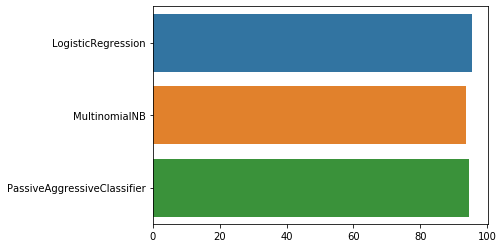

In [42]:
# visualisation of Accuracy Score
sns.barplot(y=Model,x=Acc_score)

#### After all this process conclusion is that Passive Aggressive Classifier is giving accuracy of 94.72%, So now I am making a final model using Passive Aggressive Classifier.

# Final Model

In [43]:
# Using PassiveAggressiveClassifier for final model...
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=57,test_size=.30,stratify=y)
PAC=PassiveAggressiveClassifier()
PAC.fit(x_train,y_train)
PAC.score(x_train,y_train)
PACpred=PAC.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,PACpred))
print('Log loss : ', log_loss(y_test,PACpred))
print('Confusion Matrix:',confusion_matrix(y_test,PACpred))
print('Classification Report:','\n',classification_report(y_test,PACpred))

Accuracy Score: 0.9453333890374331
Log loss :  1.8881408687905268
Confusion Matrix: [[ 3490  1378]
 [ 1239 41765]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.72      0.73      4868
           1       0.97      0.97      0.97     43004

    accuracy                           0.95     47872
   macro avg       0.85      0.84      0.85     47872
weighted avg       0.94      0.95      0.94     47872



(2.5, -0.5)

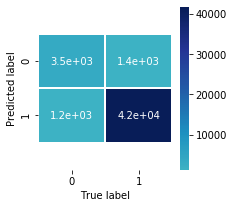

In [44]:
# Confusion matrix Visualization
fig, ax =plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix(y_test, PACpred),annot=True,linewidths=1,center=0,cmap='YlGnBu')
plt.xlabel("True label")
plt.ylabel("Predicted label")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Text(0.5, 1.0, 'PassiveAggressiveClassifier')

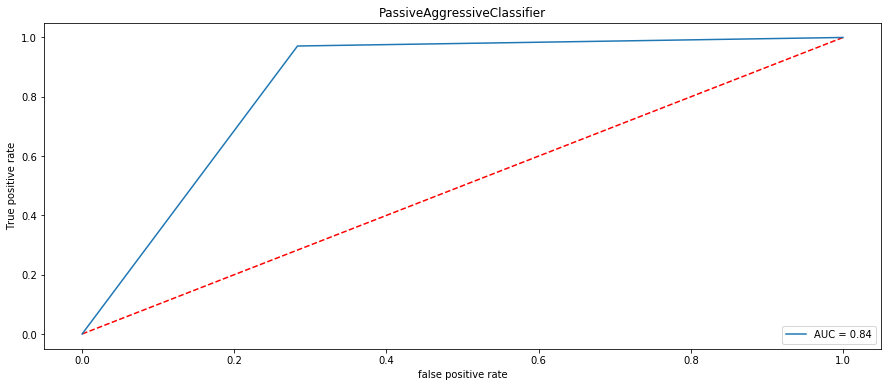

In [45]:
# Roc-Auc score
f,ax = plt.subplots(figsize = (15,6))
# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, PACpred)
ax.plot([0,1],[0,1],'r--')
ax.plot(fpr,tpr,label='AUC = %0.2f'% roc_auc_score(y_test, PACpred))
ax.legend(loc='lower right')
ax.set_xlabel('false positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('PassiveAggressiveClassifier')

In [46]:
def Tf_idf_test(text):
    tfid = TfidfVectorizer(max_features=43194,smooth_idf=False)
    return tfid.fit_transform(text)

In [47]:
# PREDICT
# cleaning the news and storing them in a separate feature...

comments_test["clean_comment_text"] = comments_test["comment_text"].apply(lambda x: Processed_data(x))

# Inserting vectorized values in a variable x, which will be used in training the model 
x_testing_data=Tf_idf_test(comments_test['clean_comment_text'])

In [48]:
x_testing_data.shape

(153164, 43194)

In [49]:
# Printing predicted values
Prediction=PAC.predict(x_testing_data)
comments_test['Predicted values']=Prediction
comments_test
# On the left side values are those which are taken by machine for test...

id                                       comment_text  \
0       00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...   
1       0000247867823ef7  == From RfC == \n\n The title is fine as it is...   
2       00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...   
3       00017563c3f7919a  :If you have a look back at the source, the in...   
4       00017695ad8997eb          I don't anonymously edit articles at all.   
...                  ...                                                ...   
153159  fffcd0960ee309b5  . \n i totally agree, this stuff is nothing bu...   
153160  fffd7a9a6eb32c16  == Throw from out field to home plate. == \n\n...   
153161  fffda9e8d6fafa9e  " \n\n == Okinotorishima categories == \n\n I ...   
153162  fffe8f1340a79fc2  " \n\n == ""One of the founding nations of the...   
153163  ffffce3fb183ee80  " \n :::Stop already. Your bullshit is not wel...   

                                       clean_comment_text  Predicted values  
0       bitch rule succesful whats hating mofuckas bit...                 1  
1                                              title fine                 1  
2                              source zawe ashton lapland                 1  
3       look source information updated correct form g...                 0  
4                                anonymously edit article                 1  
...                                                   ...               ...  
153159                      totally agree stuff long crap                 1  
153160  throw field home plate faster throwing direct ...                 1  
153161  okinotorishima category change agree correct g...                 0  
153162  founding nation germany return similar israel ...                 1  
153163  stop bullshit welcome fool think kind explinat...                 1  

[153164 rows x 4 columns]

In [52]:
# Saving the Predicted values in csv file
comments_test.to_csv('Malignant_Comment_Classifier_Predict.csv') 